In [2]:
%matplotlib inline
import numpy as np
import pandas
import matplotlib.pyplot as pl
import math
import matplotlib as mpl
from sklearn.utils import resample
from matplotlib import cm
import multiprocessing as mp
import time
import sys

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-4:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_analysis as aims

# Let's try to clean stuff up by defining functions for all the stuff we call

In [3]:
# Define plots
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 16}
COLOR = 'black'
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

mpl.rc('font', **font)

# Run the bootstrapping in a separate script, then load it back in here
Think I've mentioned it before, but actually all of the bootstrapping is run on a supercomputer

In [5]:
import seq_loader
[mono_all,poly_all,mono,poly]=seq_loader.getBunker()
[mono_jennaAll,poly_jennaAll,mono_jenna,poly_jenna]=seq_loader.getJenna()
[mono_HugoAll,poly_HugoAll,mono_Hugo,poly_Hugo]=seq_loader.getHugo()
[mono_HugNat_all,poly_HugNat_all,mono_HugNat,poly_HugNat]=seq_loader.getHugo_Nature()
[mono_PLOS,poly_PLOS]=seq_loader.getHugo_PLOS()
[mono_HugNat_allCNT,poly_HugNat_allCNT,mono_HugNatCNT,poly_HugNatCNT] = seq_loader.getHugo_NatCNTRL()
AA_key,AA_num_key,AA_num_key_new,props=aims.get_props()

In [6]:
# Make the matrices
# So this is our "full" dataset. Including those antibodies reactive to an intermediate number of ligands
#ALL_mono=np.hstack((mono_all,mono_jennaAll,mono_HugoAll,mono_HugNat_all,mono_HugNat_allCNT,mono_PLOS))
#ALL_poly=np.hstack((poly_all,poly_jennaAll,poly_HugoAll,poly_HugNat_all,poly_HugNat_allCNT,poly_PLOS))

# This is actually our parsed dataset, but keep names so we don't need to make multiple changes
#ALL_mono=np.hstack((mono,mono_jenna,mono_Hugo,mono_HugNat,mono_HugNatCNT,mono_PLOS))
#ALL_poly=np.hstack((poly,poly_jenna,poly_Hugo,poly_HugNat,poly_HugNatCNT,poly_PLOS))
import aims_loader as aimsLoad
num_loop=6
label = ['poly','mono']
ALL_mono = aimsLoad.Ig_loader('/Users/boughter/Desktop/ryan_data/WT_Treg_AIMS_allCDRs.csv',label = label[0], loops=num_loop,drop_degens = False)
ALL_poly = aimsLoad.Ig_loader('/Users/boughter/Desktop/ryan_data/WT_Tconv_AIMS_allCDRs.csv',label = label[1], loops=num_loop,drop_degens = False)

poly_all_MI,mono_all_MI,allSize=aims.gen_tcr_matrix(np.array(ALL_poly),pre_mono=np.array(ALL_mono),key = AA_num_key,binary=True,
                                                    return_Size=True,manuscript_arrange=True)

#ALL_human=np.hstack((mono_jennaAll,mono_HugoAll,mono_HugNat_all,mono_HugNat_allCNT,mono_PLOS))
#ALL_human=np.hstack((poly_jennaAll,poly_HugoAll,poly_HugNat_all,poly_HugNat_allCNT,poly_PLOS))
#poly_all_MI,mono_all_MI,allSize=aims.gen_tcr_matrix(ALL_poly,pre_mono=ALL_mono,key = AA_num_key,binary=True,return_Size=True)

# Do this so we guarantee we are always dealing with the same matrix size
max_len = [int(i) for i in allSize]
max_all = [max_len[0],max_len[1],max_len[2],max_len[3],max_len[4],max_len[5]]

In [7]:
# Obviously change this to your dir location
#dir1 = '/Users/boughter/Desktop/data2020/marta_fabs/CDR_jupyter/booted/full_boot_071020'
#dir1 = '/Users/boughter/Desktop/data2020/marta_fabs/CDR_jupyter/booted/revision_parse_boot'
dir1 = '/Users/boughter/Desktop/ryan_data'
single_bootM = np.load(dir1+'/sinAvg_mono_boot_all.npy'); single_bootMstd = np.load(dir1+'/sinStd_mono_boot_all.npy')
single_bootP = np.load(dir1+'/sinAvg_poly_boot_all.npy'); single_bootPstd = np.load(dir1+'/sinStd_poly_boot_all.npy')

len_bootP = np.load(dir1+'/len_poly_boot_all.npy'); len_bootPstd = np.load(dir1+'/len_polyStd_boot_all.npy')
len_bootM = np.load(dir1+'/len_mono_boot_all.npy'); len_bootMstd = np.load(dir1+'/len_monoStd_boot_all.npy')

dset_bootP = np.load(dir1+'/dset_poly_boot_all.npy')
dset_bootM = np.load(dir1+'/dset_mono_boot_all.npy')

boot_props_poly = dset_bootP[:,0,:,:]
boot_props_mono = dset_bootM[:,0,:,:]
boot_props_polyStd = dset_bootP[:,1,:,:]
boot_props_monoStd = dset_bootM[:,1,:,:]

MI_bootP = np.load(dir1+'/MI_poly_boot_all.npy')
MI_bootM = np.load(dir1+'/MI_mono_boot_all.npy')

count_bootP = np.load(dir1+'/count_poly_boot_all.npy')
count_bootM = np.load(dir1+'/count_mono_boot_all.npy')

# Note, below data will look different from manuscript
For the manuscript, I felt the changing of the y-axis size in each plot was confusing/misleading. So for that, max_all = [31, 31, 31, 31, 31, 31]. This way, the size of each position is uniform. You can see below "block size" changes with loop currently

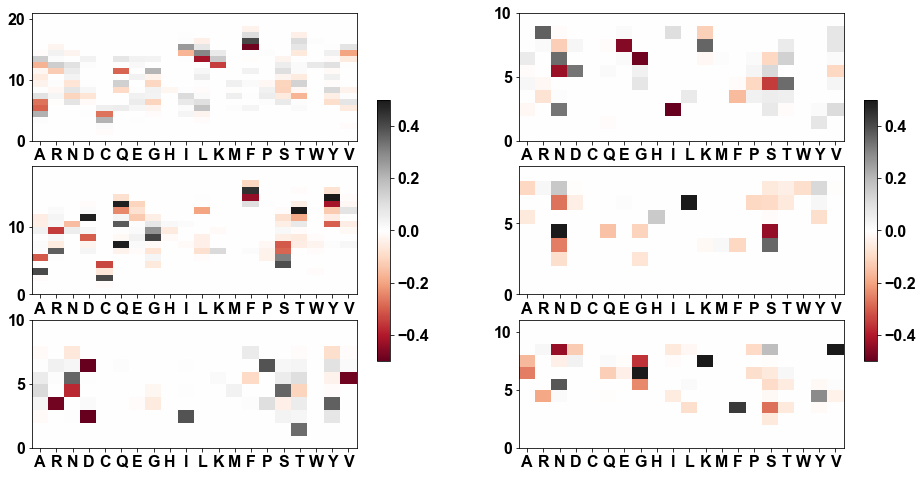

In [26]:
fig, ax = pl.subplots(3, 2,squeeze=False,figsize=(16,8))
AA_key,AA_num_key,AA_num_key_new,props=aims.get_props()

poly_c=np.average(count_bootP,axis=0)
mono_c=np.average(count_bootM,axis=0)

# As a quick reference, going clockwise from the top right we have CDR3H, 2H, 1H
# then bottom left 1L up to 2L, and 3L in the top left

for i in np.arange(6):
    loc1 = sum(max_all[:i])
    loc2 = sum(max_all[:i]) + max_all[i]
    if i < 3:
        x=ax[i,0].pcolormesh(poly_c[loc1:loc2,1:]-mono_c[loc1:loc2,1:],vmin=-0.5,vmax=0.5,cmap=cm.RdGy)
    else:
        j=i-3
        x=ax[j,1].pcolormesh(poly_c[loc1:loc2,1:]-mono_c[loc1:loc2,1:],vmin=-0.5,vmax=0.5,cmap=cm.RdGy)
    
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=AA_key)
fig.colorbar(x, ax=ax[:, 1], shrink=0.6)
fig.colorbar(x, ax=ax[:, 0], shrink=0.6)
fig.savefig('AA_RyanData_CBAR.pdf',format='pdf',dpi=500)

# Below Code Block is then the more easily appreciated quantitation of above Figure
So above is panel 2B, below is panel 2C

Pos 33
T
0.5447006906946038
Pos 42
D
0.5257794331428285
Pos 46
D
0.6585970452662793
Pos 52
I
0.5632456053297862
Pos 64
N
0.7017677241426921
Pos 66
L
0.5483247755537014
Pos 75
G
0.5483247755537014
Pos 76
K
0.5308316272152294
Pos 77
V
0.5425180830392337


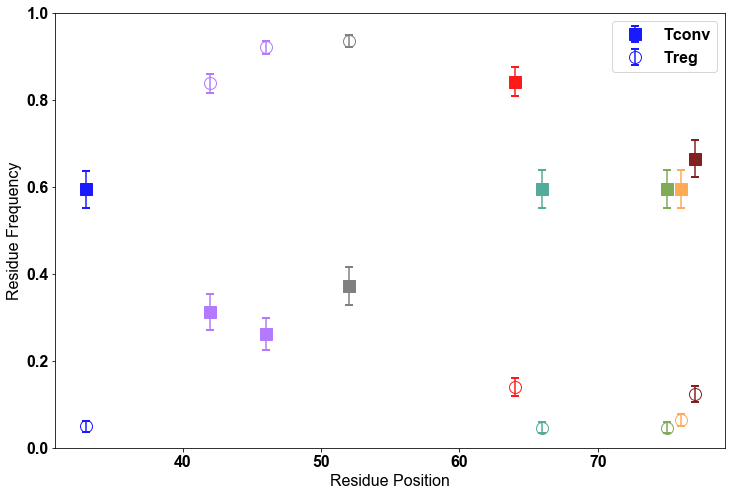

In [36]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(12,8))

poly_c=np.average(count_bootP,axis=0)
mono_c=np.average(count_bootM,axis=0)
poly_c_std=np.std(count_bootP,axis=0)
mono_c_std=np.std(count_bootM,axis=0)

a,b=np.shape(poly_c)
x=0
for i in np.arange(a):
    for j in np.arange(b):
        diffy=np.abs(poly_c[i,j]-mono_c[i,j])
        if diffy > 0.5:
            if i < 90:
                pos=0
            elif i > 90:
                pos=1
            resi=AA_key[j-1]
            if resi == 'T': # Blue
                cc=[0.1,0.1,1.0]
            elif resi == 'D': # Purple
                cc=[0.471*1.5, 0.318*1.5, 0.663*1.5]
            elif resi == 'I': # Grey
                cc=[0.5,0.5,0.5] 
            elif resi == 'N': # Red
                cc=[1.0,0.1,0.1]
            elif resi == 'L': # Blue-Green
                cc=[0.33,0.67,0.6]
            elif resi =='K': # yellow
                cc=[1.0,0.666,0.333]
            elif resi =='G':
                cc = [0.5,0.666,0.333]
            elif resi =='V':
                cc = [0.5,0.125,0.125]
            else:
                cc=[0.0,0.0,0.0]
            ax[0,pos].errorbar(i,poly_c[i,j],yerr=poly_c_std[i,j],fmt='s',markersize=12,color=cc,capsize=4,capthick=2)
            ax[0,pos].errorbar(i,mono_c[i,j],yerr=mono_c_std[i,j],fmt='o',markersize=12,color=cc,capsize=4,capthick=2,fillstyle='none')
            print('Pos '+str(i))
            print(AA_key[j-1])
            print(diffy)
ax[0,0].set_ylim([0,1.0])
# This is the xlim for the parse data
#ax[0,0].set_xlim([76,82])
# Don't bother setting for the non-parse data

#ax[0,1].set_ylim([0,0.8])

pl.legend(['Tconv','Treg'])
pl.xlabel('Residue Position')
pl.ylabel('Residue Frequency')
fig.savefig('AA_parse_0.5Cut.pdf',format='pdf',dpi=500)

# NEED TO WRITE THE CODE FOR THE BELOW SECTION

In [37]:
# Let's just straight up calculate Shannon entropy from saved cond. probs.

reps,size,aas=np.shape(count_bootP)
x=0
# Note, num reps may not equal reps. For my bootstraps,
# I ran them in parallel on 112 cores. 1008 is a mutliple
# of 112, so I have 1008 reps. But for cleanliness, only
# use the first 1000
num_reps = 1000
boot_shannon_poly = np.zeros([num_reps,size])
boot_shannon_mono = np.zeros([num_reps,size])

for i in np.arange(1000):
    for j in np.arange(size):
        for k in np.arange(aas):
            # count_boot is actually probabilities, not a raw count
            # sorry for the misnomer.
            if count_bootP[i,j,k] != 0:
                boot_shannon_poly[i,j] += -count_bootP[i,j,k]*math.log2(count_bootP[i,j,k])
            if count_bootM[i,j,k] != 0:
                boot_shannon_mono[i,j] += -count_bootM[i,j,k]*math.log2(count_bootM[i,j,k])

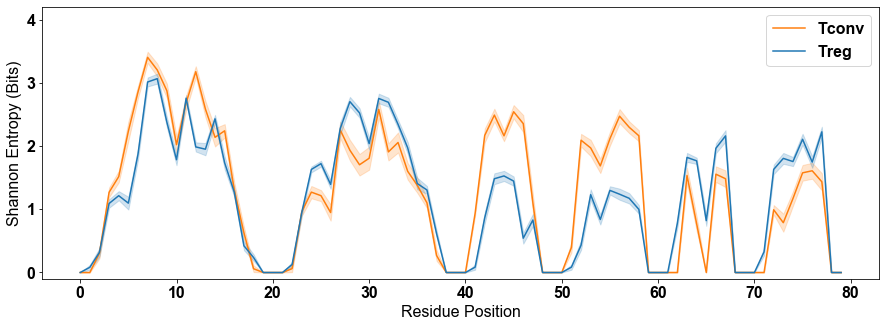

In [91]:
poly_S=np.average(boot_shannon_poly,axis=0)
mono_S=np.average(boot_shannon_mono,axis=0)
poly_S_std=np.std(boot_shannon_poly,axis=0)
mono_S_std=np.std(boot_shannon_mono,axis=0)

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(15,5))
pl.plot(poly_S,'C1')
pl.fill_between(np.arange(len(poly_S)),poly_S+poly_S_std,poly_S-poly_S_std,color='C1',alpha=0.2)
pl.plot(mono_S,'C0')
pl.fill_between(np.arange(len(mono_S)),mono_S+mono_S_std,mono_S-mono_S_std,color='C0',alpha=0.2)

#pl.xlim([0,103])
pl.ylim([-0.1,4.2])
pl.legend(['Tconv','Treg'])
pl.xlabel('Residue Position')
pl.ylabel('Shannon Entropy (Bits)')
fig.savefig('parse_booted_shannon.pdf',format='pdf',dpi=500)

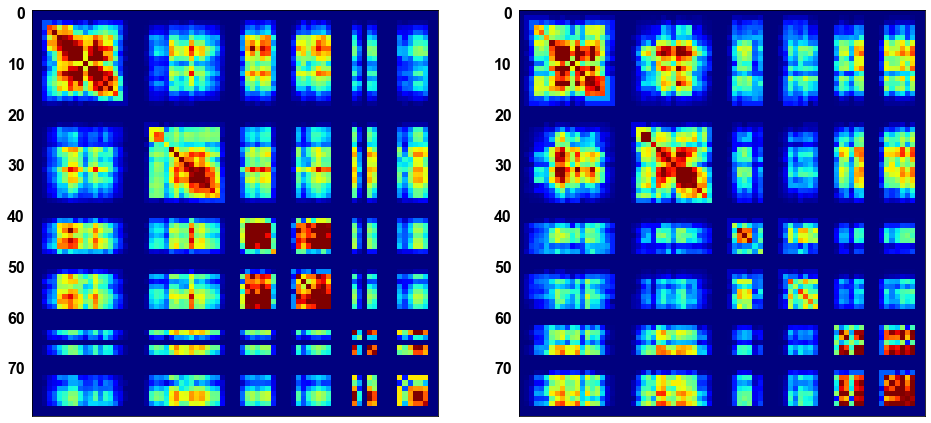

In [40]:
boot_MI_poly = MI_bootP
boot_MI_mono = MI_bootM

fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(16,8))
MI_poly=np.average(boot_MI_poly,axis=0)
MI_mono=np.average(boot_MI_mono,axis=0)
MI_poly_std=np.std(boot_MI_poly,axis=0)
MI_mono_std=np.std(boot_MI_mono,axis=0)
cool1=ax[0,0].imshow(MI_poly,vmin=0,vmax=1.5,cmap=cm.jet)
ax[0,1].imshow(MI_mono,vmin=0,vmax=1.5,cmap=cm.jet)
#pl.colorbar(cool1)
ax[0,0].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False)
ax[0,1].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False) 
#fig.savefig('therapeutic_MIs.pdf',format='pdf',dpi=500)

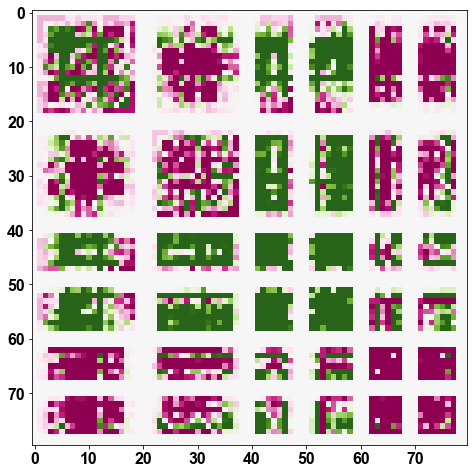

In [41]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x=pl.imshow(MI_poly-MI_mono,vmin=-0.20,vmax=0.20,cmap=cm.PiYG)
#pl.colorbar(x)
#fig.savefig('parse_MI_differenceMap.pdf',format='pdf',dpi=500)

### Below Section is how we pick out individual slices from the above matrix.
Change "Resi" to slide along the matrix anywhere from 0 to max_len

Text(0, 0.5, 'Mutual Information (Bits)')

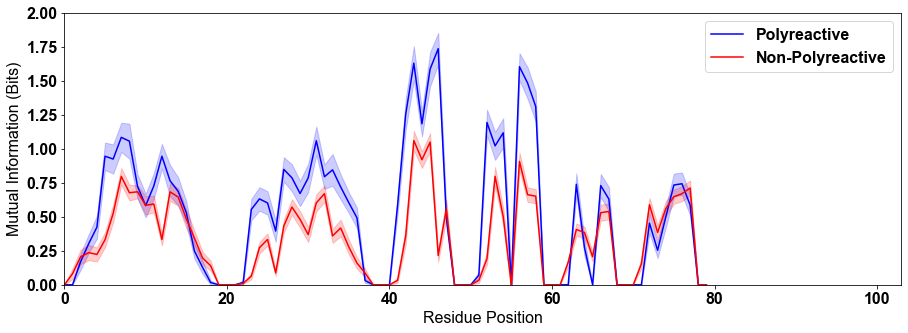

In [52]:
resi=55
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(15,5))
MI_poly_plot = MI_poly
MI_mono_plot = MI_mono
MI_poly_plot[resi][resi] = 0
MI_mono_plot[resi][resi] = 0
pl.plot(MI_poly_plot[resi],'b')
pl.fill_between(np.arange(len(MI_poly_plot[resi])),MI_poly_plot[resi]+MI_poly_std[resi],MI_poly[resi]-MI_poly_std[resi],color='b',alpha=0.2)
pl.plot(MI_mono[resi],'r')
pl.fill_between(np.arange(len(MI_mono[resi])),MI_mono[resi]+MI_mono_std[resi],MI_mono[resi]-MI_mono_std[resi],color='r',alpha=0.2)

# Commented out stuff is for plotting p-values
#hold = True
#for i in np.arange(len(p_matrix[resi])):
#    if p_matrix[resi,i] < 0.05:
#        if hold:
#            plotP = 1.8
#            xP = i
#            hold = False
#        else:
#            plotP = np.vstack((plotP,1.8))
#            xP = np.vstack((xP,i))

#pl.scatter(xP,plotP,color='black')
            
pl.xlim([0,103])
pl.ylim([0,2.0])
#pl.legend(['Polyreactive','Monoreactive'])
pl.legend(['Polyreactive','Non-Polyreactive'])
pl.xlabel('Residue Position')
pl.ylabel('Mutual Information (Bits)')
#fig.savefig('booted_MI_single'+str(resi)+'_fullData.pdf',format='pdf',dpi=500)

# Plot the Average Length from Bootstraps

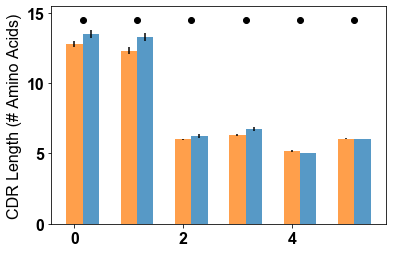

In [90]:
for prop in np.arange(6):
    #zalphO2=1.960 # this is 95% CI.
    zalphO2=2.576 # This is 99% CI
    #mono_prop_avg=np.average(len_bootM_null[0:1000,prop])
    #poly_prop_avg=np.average(len_bootP_null[0:1000,prop])
    mono_prop_avg=np.average(len_bootM[0:1000,prop])
    poly_prop_avg=np.average(len_bootP[0:1000,prop])
    
    #mono_prop_std=(np.std(len_bootM_null[0:1000,prop]))*zalphO2
    #poly_prop_std=(np.std(len_bootP_null[0:1000,prop]))*zalphO2

    mono_prop_std=(np.std(len_bootM[0:1000,prop]))*zalphO2
    poly_prop_std=(np.std(len_bootP[0:1000,prop]))*zalphO2

    pl.bar(prop,mono_prop_avg,yerr=mono_prop_std,color='C1',alpha=0.75,width=0.3)
    pl.bar(prop+0.3,poly_prop_avg,yerr=poly_prop_std,color='C0',alpha=0.75,width=0.3)
    pl.ylabel('CDR Length (# Amino Acids)')

# Also for plotting p-values
for i in np.arange(len(pBoot_len)):
    if pBoot_len[i] < 0.05/6:
        pl.scatter(i+0.15,14.5,color='black')
pl.savefig('CDR_len_sigs.pdf',format='pdf',dpi=500)

# Plot Average Biophysical Properties

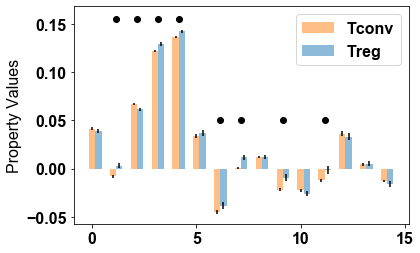

In [86]:
for prop in np.arange(15):
    #zalphO2=1.960 # this is 95% CI.
    zalphO2=2.576 # This is 99% CI
    mono_prop_avg=np.average(single_bootM[0:1000,prop])
    poly_prop_avg=np.average(single_bootP[0:1000,prop])
    
    mono_prop_std=(np.std(single_bootM[0:1000,prop]))*zalphO2
    poly_prop_std=(np.std(single_bootP[0:1000,prop]))*zalphO2

    pl.bar(prop,mono_prop_avg,yerr=mono_prop_std,color='C1',alpha=0.5,width=0.3)
    pl.bar(prop+0.3,poly_prop_avg,yerr=poly_prop_std,color='C0',alpha=0.5,width=0.3)
    pl.ylabel('Property Values')

    pl.legend(['Tconv','Treg'])

# For plotting p-values
for i in np.arange(len(pBoot_prop)):
    # The "divide by 15" is for multiple test correction
    if pBoot_prop[i] < 0.05/15:
        if i < 5:
            pl.scatter(i+0.15,0.155,color='black')
        else:
            pl.scatter(i+0.15,0.05,color='black')
pl.savefig('CDR_prop_parse_sigs.pdf',format='pdf',dpi=500)

# And Lastly for New Plots: Position Sensitive Properties

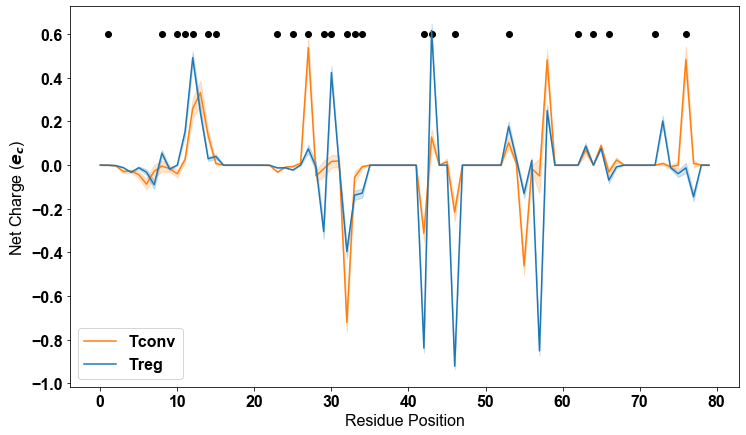

In [14]:
poly_S=np.average(boot_props_poly,axis=0)
mono_S=np.average(boot_props_mono,axis=0)
poly_S_std=np.std(boot_props_poly,axis=0)
mono_S_std=np.std(boot_props_mono,axis=0)

# Take a peek at the null properties
#poly_S=np.average(boot_props_poly_null,axis=0)
#mono_S=np.average(boot_props_mono_null,axis=0)
#poly_S_std=np.std(boot_props_poly_null,axis=0)
#mono_S_std=np.std(boot_props_mono_null,axis=0)

# Prop numbers are the EXACT SAME as in aims_analysis.ipynb
prop = 2
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(12,7))
pl.plot(poly_S[prop],'C1')
pl.fill_between(np.arange(len(poly_S[prop])),poly_S[prop]+poly_S_std[prop],poly_S[prop]-poly_S_std[prop],color='C1',alpha=0.2)
pl.plot(mono_S[prop],'C0')
pl.fill_between(np.arange(len(mono_S[prop])),mono_S[prop]+mono_S_std[prop],mono_S[prop]-mono_S_std[prop],color='C0',alpha=0.2)

pl.legend(['Tconv','Treg'])
pl.xlabel('Residue Position')
pl.ylabel('Net Charge ($e_c$)')
#pl.ylabel('Net Hydrophobicity (AU)')

# for plotting p-values
for i in np.arange(len(booted_ps)):
    if booted_ps[i] < 0.05:
        pl.scatter(i,0.6,color='black')
#        pl.scatter(i,0.25,color='black')

#pl.savefig('parse_phob_sig.pdf',format='pdf',dpi=500)

# Now, into significance testing
To do so, we need to load in both permuted data (for mutual information) and "scrambled data" for every other statistical test

In [8]:
# Obviously change this to your dir location
dir1 = '/Users/boughter/Desktop/data2020/marta_fabs/CDR_jupyter/booted'

MI_bootP_perm = np.load(dir1+'/parse_permute'+'/MI_poly_boot_all.npy')
MI_bootM_perm = np.load(dir1+'/parse_permute'+'/MI_mono_boot_all.npy')
dset_bootP_perm = np.load(dir1+'/parse_permute'+'/dset_poly_boot_all.npy')
dset_bootM_perm = np.load(dir1+'/parse_permute'+'/dset_mono_boot_all.npy')
boot_props_poly_perm = dset_bootP_perm[:,0,:,:]
boot_props_mono_perm = dset_bootM_perm[:,0,:,:]

# And load in the null distribution data:
#dir2 = '/null_full'
dir2='/parse_null'
dir3 = dir1+dir2

single_bootM_null = np.load(dir3+'/sinAvg_mono_boot_all.npy'); single_bootMstd_null = np.load(dir3+'/sinStd_mono_boot_all.npy')
single_bootP_null = np.load(dir3+'/sinAvg_poly_boot_all.npy'); single_bootPstd_null = np.load(dir3+'/sinStd_poly_boot_all.npy')

len_bootP_null = np.load(dir3+'/len_poly_boot_all.npy'); len_bootPstd_null = np.load(dir3+'/len_polyStd_boot_all.npy')
len_bootM_null = np.load(dir3+'/len_mono_boot_all.npy'); len_bootMstd_null = np.load(dir3+'/len_monoStd_boot_all.npy')

dset_bootP_null = np.load(dir3+'/dset_poly_boot_all.npy')
dset_bootM_null = np.load(dir3+'/dset_mono_boot_all.npy')

boot_props_poly_null = dset_bootP_null[:,0,:,:]
boot_props_mono_null = dset_bootM_null[:,0,:,:]
boot_props_polyStd_null = dset_bootP_null[:,1,:,:]
boot_props_monoStd_null = dset_bootM_null[:,1,:,:]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/boughter/Desktop/data2020/marta_fabs/CDR_jupyter/booted/parse_permute/MI_poly_boot_all.npy'

# We Also Need to Calculate Non-Bootstrapped Values
For statistical tests, we want to show the empirical distribution

In [9]:
# Also need to calculate the non-bootstrapped values
mono = np.array(ALL_mono)
poly = np.array(ALL_poly)
len_distM=np.zeros((6,len(mono[0])))
len_distP=np.zeros((6,len(poly[0])))
for i in [0,1,2,3,4,5]: # This one for light
        for j in np.arange(len(mono[0])):
            len_distM[i,j]=len(mono[i][j])
        for j in np.arange(len(poly[0])):
            len_distP[i,j]=len(poly[i][j])

# Average and take std
len_meanM=np.average(len_distM,axis=1)
len_meanP=np.average(len_distP,axis=1)
len_stdM=np.std(len_distM,axis=1)
len_stdP=np.std(len_distP,axis=1)

# Now get properties, not lengths:
clone_meansM=aims.gen_clone_props(mono_all_MI)
clone_meansP=aims.gen_clone_props(poly_all_MI)
mean_varsM=np.average(clone_meansM,axis=1)
mean_varsP=np.average(clone_meansP,axis=1)
std_varsM=np.std(clone_meansM,axis=1)
std_varsP=np.std(clone_meansP,axis=1)

# And non-averaged properties:
nonBoot_poly,nonBoot_polyStd=aims.gen_dset_props(poly_all_MI,stdev=True)
nonBoot_mono,nonBoot_monoStd=aims.gen_dset_props(mono_all_MI,stdev=True)

# And non-averaged MI:
nonBoot_MI_poly=aims.calculate_MI(poly_all_MI)[0]
nonBoot_MI_mono=aims.calculate_MI(mono_all_MI)[0]

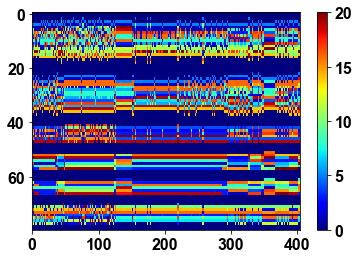

In [10]:
total_dat = np.vstack((poly_all_MI,mono_all_MI))
matrix=pl.imshow(np.transpose(total_dat[:,:]), interpolation='nearest', aspect='auto',cmap=cm.jet)
pl.colorbar(matrix)

# Generate the P-value matrix of Supplemental Figure S7
We need to use the permutation test, because our MI calculation doesn't have a non-bootstrapped standard deviation
Method from Page 158 of "Bootstrap Methods and Their Application" - A.C. Davison and D.V. Hinkley

In [65]:
num_reps = 1000
booted_ps = 0
length = np.shape(MI_bootP)[2]
p_matrix = np.ones((length,length))
# MI is the only data in matrix form, so I need to account for that
for pos1 in np.arange(length):
    for pos2 in np.arange(length):
        
        # z is our test statistic, and here it is simply a difference of means
        z0 = MI_poly[pos1,pos2]-MI_mono[pos1,pos2]
        # Go across all permutations
        a = 0
        for i in np.arange(num_reps):
            z_r = MI_bootP_perm[i,pos1,pos2] - MI_bootM_perm[i,pos1,pos2]
            
            # We want to count the number of times the permuted z is larger
            # than the empirical z0. Square both z's to make it a 2-sided test
            if z_r**2 >= z0**2:
                a = a + 1

        p_boot = (a+1)/(num_reps+1)
        
        if p_boot < 0.05:
            p_matrix[pos1,pos2] = p_boot

NameError: name 'MI_bootP_perm' is not defined

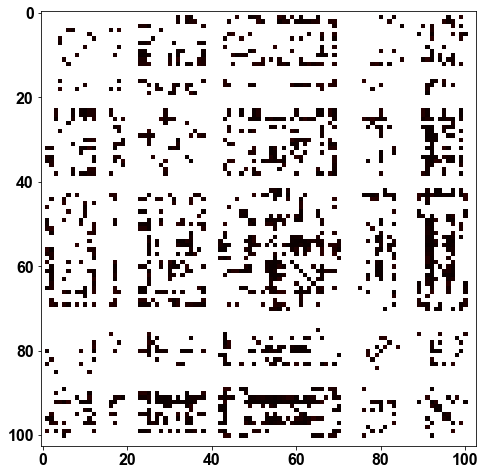

In [11]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x = pl.imshow(p_matrix,cmap='hot')
#fig.savefig('MI_significance_matrixPARSE.pdf',format='pdf',dpi=500)

# All of the Below Code Uses a Studentized Non-Parametric Bootstrap Significance Test:
Test for Studentized Statistical Significance as in "Bootstrap Methods and Their Application" pg 171-172
Once these are calculated, you could go back up this notebook and actually plot the "stars" for significance

# Calculate significance for CDR length

In [11]:
# loops are 0,1,2,3,4,5
# for cdr1,2,3 light then cdr1,2,3 heavy
num_mono = np.shape(ALL_mono)[1]
num_poly = np.shape(ALL_poly)[1]
# num_reps is the number of bootstrapped samples taken
num_reps = 1000
for loop in np.arange(6):
    exp_diff = len_meanP[loop] - len_meanM[loop]
    z0 =  (len_meanP[loop] - len_meanM[loop])/np.sqrt((len_stdP[loop]**2)/num_poly + (len_stdM[loop]**2)/num_mono)
    a = 0
    for i in np.arange(num_reps):
        #z_r =  (len_bootP_null[i,loop] - len_bootM_null[i,loop])/np.sqrt((len_bootPstd_null[i,loop]**2)/num_poly + (len_bootMstd_null[i,loop]**2)/num_mono)
        z_r =  ((len_bootP[i,loop] - len_bootM[i,loop])-exp_diff)/np.sqrt((len_bootPstd[i,loop]**2)/num_poly + (len_bootMstd[i,loop]**2)/num_mono)
        
        if z_r**2 >= z0**2:
            a = a + 1
        if i == 0:
            zR = z_r**2
        else:
            zR = np.vstack((zR,z_r**2))
        p_boot = (a+1)/(num_reps+1)
    if loop == 0:
        pBoot_len = p_boot
    else:
        pBoot_len = np.hstack((pBoot_len,p_boot))
print(pBoot_len)
# Can optionally visualize the number of replicas that break through the limit
#pl.plot(zR)
#pl.plot(z0**2*np.ones(1000))

[0.000999 0.000999 0.000999 0.000999 0.000999 0.003996]


# Calculate Significance for Averaged Biophysical Properties:

In [67]:
# Same deal as above for num_reps
num_reps = 1000
for prop in np.arange(15):
    exp_diff = (mean_varsP[prop] - mean_varsM[prop])
    z0 =  (mean_varsP[prop] - mean_varsM[prop])/np.sqrt((std_varsP[prop]**2)/num_poly + (std_varsM[prop]**2)/num_mono)
    a = 0
    for i in np.arange(num_reps):
        #z_r =  (single_bootP_null[i,prop] - single_bootM_null[i,prop])/np.sqrt((single_bootPstd_null[i,prop]**2)/num_poly + (single_bootMstd_null[i,prop]**2)/num_mono)
        z_r =  (single_bootP[i,prop] - single_bootM[i,prop]-exp_diff)/np.sqrt((single_bootPstd[i,prop]**2)/num_poly + (single_bootMstd[i,prop]**2)/num_mono)
        if z_r**2 >= z0**2:
            a = a + 1

    p_boot = (a+1)/(num_reps+1)
    
    if prop == 0:
        pBoot_prop = p_boot
    else:
        pBoot_prop = np.hstack((pBoot_prop,p_boot))
print(pBoot_prop)

[0.02397602 0.000999   0.000999   0.000999   0.000999   0.06793207
 0.000999   0.000999   0.97502498 0.000999   0.00599401 0.000999
 0.06993007 0.71028971 0.00799201]


# Lastly, calculate significance for our position sensitive biophysical properties
To have a bit more control, we do these one property at a time

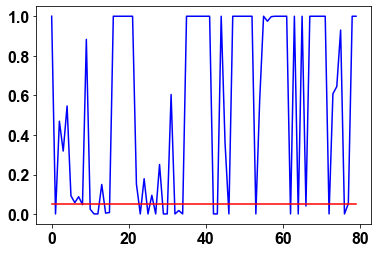

In [12]:
prop = 2
num_reps = 1000
a = 0
#booted_ps = 0
length = np.shape(boot_props_poly)[2]
for pos in np.arange(length):
    if nonBoot_polyStd[prop,pos] == 0 and nonBoot_monoStd[prop,pos] == 0:
        p_boot = 1 
        if pos == 0:
            booted_ps = p_boot
        else:
            booted_ps = np.vstack((booted_ps,p_boot))
        continue
    exp_diff = (nonBoot_poly[prop,pos] - nonBoot_mono[prop,pos])
    z0 =  (nonBoot_poly[prop,pos] - nonBoot_mono[prop,pos])/np.sqrt((nonBoot_polyStd[prop,pos]**2)/num_poly + (nonBoot_monoStd[prop,pos]**2)/num_mono)
    a = 0
    for i in np.arange(num_reps):
        if boot_props_polyStd[i,prop,pos] == 0 and boot_props_polyStd[i,prop,pos] == 0:
        #if boot_props_polyStd_null[i,prop,pos] == 0 and boot_props_polyStd_null[i,prop,pos] == 0:
            continue
        #z_r = (boot_props_poly_null[i,prop,pos] - boot_props_mono_null[i,prop,pos])/np.sqrt((boot_props_polyStd_null[i,prop,pos]**2)/num_poly + (boot_props_monoStd_null[i,prop,pos]**2)/num_mono)
        z_r = (boot_props_poly[i,prop,pos] - boot_props_mono[i,prop,pos] - exp_diff)/np.sqrt((boot_props_polyStd[i,prop,pos]**2)/num_poly + (boot_props_monoStd[i,prop,pos]**2)/num_mono)

        if z_r**2 >= z0**2:
            a = a + 1

    p_boot = (a+1)/(num_reps+1)
    # Need to turn this into a float for some weird reason
    if pos == 0:
        booted_ps = p_boot
    else:
        booted_ps = np.vstack((booted_ps,p_boot))

pl.plot(booted_ps,color='blue')
pl.plot(np.arange(length),0.05*np.ones(length),color='r')

# At the very bottom here is how I compile my bootstrapped properties. This is necessary because of how I actually run the bootstraps (as "swarms of bootstraps" across multiple high performance compute nodes.
I'll be sure to include that code in some directory at some point...

In [3]:
# CONCATENATE ALL OF THE FILES
#set = 'mouseParse'
#dir1 = '/Users/boughter/Desktop/data2020/marta_fabs/CDR_jupyter/booted/'
dir1 = '/Users/boughter/Desktop/ryan_data/'

#dir2 = 'null_'+set+'/non_compile'
#dir2 = set+'_midway_boot/non_compile'
# This directory is used for the full dataset, what appears in the paper
#dir2 = 'full_permute'

# This directory is for the therapeutics, obviously
#dir2 = 'THERA_midwayBoot070120'
#dir2 = 'parse_permute'

dir3 = dir1 #+dir2

# 112 is not the number of locations, but instead the number of
# nodes that these were run on
for i in np.arange(112):
    a = i + 1
    x = np.load(dir3+'/len_poly_boot.'+str(a)+'.npy')
    y = np.load(dir3+'/len_mono_boot.'+str(a)+'.npy')
    x1 = np.load(dir3+'/lenStd_poly_boot.'+str(a)+'.npy')
    y1 = np.load(dir3+'/lenStd_mono_boot.'+str(a)+'.npy')
    
    b = np.load(dir3+'/sinAvg_poly_boot.'+str(a)+'.npy')
    c = np.load(dir3+'/sinAvg_mono_boot.'+str(a)+'.npy')
    b1 = np.load(dir3+'/sinStd_poly_boot.'+str(a)+'.npy')
    c1 = np.load(dir3+'/sinStd_mono_boot.'+str(a)+'.npy')
    
    d = np.load(dir3+'/dset_poly_boot.'+str(a)+'.npy')
    e = np.load(dir3+'/dset_mono_boot.'+str(a)+'.npy')
    
    aa = np.load(dir3+'/MI_poly_boot.'+str(a)+'.npy')
    bb = np.load(dir3+'/MI_mono_boot.'+str(a)+'.npy')
    
    yy = np.load(dir3+'/count_poly_boot.'+str(a)+'.npy')
    zz = np.load(dir3+'/count_mono_boot.'+str(a)+'.npy')
    
    if i ==0:
        avg1 = x
        avg2 = y
        std1 = x1
        std2 = y1
        
        avg3 = b
        avg4 = c
        std3 = b1
        std4 = c1
        
        poly = d
        mono = e
        
        MIp = aa
        MIm = bb
        
        countp = yy
        countm = zz
    else:
        avg1 = np.vstack((avg1,x))
        avg2 = np.vstack((avg2,y))
        std1 = np.vstack((std1,x1))
        std2 = np.vstack((std2,y1))
        ##
        avg3 = np.vstack((avg3,b))
        avg4 = np.vstack((avg4,c))
        std3 = np.vstack((std3,b1))
        std4 = np.vstack((std4,c1))
        
        poly = np.vstack((poly,d))
        mono = np.vstack((mono,e))
        
        MIp = np.vstack((MIp,aa))
        MIm = np.vstack((MIm,bb))
        
        countp = np.vstack((countp,yy))
        countm = np.vstack((countm,zz))

#dir2 = 'null_'+set
#dir2 = set+'_midway_boot'

dir3 = dir1#+dir2

np.save(dir3+'/len_poly_boot_all',avg1)
np.save(dir3+'/len_mono_boot_all',avg2)
np.save(dir3+'/len_polyStd_boot_all',std1)
np.save(dir3+'/len_monoStd_boot_all',std2)

np.save(dir3+'/sinAvg_poly_boot_all',avg3)
np.save(dir3+'/sinAvg_mono_boot_all',avg4)
np.save(dir3+'/sinStd_poly_boot_all',std3)
np.save(dir3+'/sinStd_mono_boot_all',std4)

np.save(dir3+'/dset_poly_boot_all',poly)
np.save(dir3+'/dset_mono_boot_all',mono)

np.save(dir3+'/MI_poly_boot_all',MIp)
np.save(dir3+'/MI_mono_boot_all',MIm)

np.save(dir3+'/count_poly_boot_all',countp)
np.save(dir3+'/count_mono_boot_all',countm)